# COVID-19 ANALYSIS

The Coronavirus disease 2019 (Covid-19) is caused by the virus SARS-CoV-2 and it was first reported in Wuhan, China in December 2019. The virus spreads through droplets produced when an infected person coughs or sneezes, and is transferred to another person through close contact like shaking hands, or touching. The spread of the virus can be prevented by frequently washing hands or using an alcohol based sanitizer, avoiding touching your face,
maintaining social distance and avoiding large gatherings. 

To combat the spread of the virus in South Africa, the government initiated a ban on all international travel, a strict lockdown that requires people to work from home and the compulsory use of face masks when going out in public. This report provides an analysis of the spread of the virus in South Africa from the 5th of March when the first case was reported until the 11th of December. It shows how cases have evolved and what effect the lockdown (from level 5 to level 1) and social distancing was on infection rates.

# Load libraries

In [146]:
import warnings
from datetime import datetime, date
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


warnings.filterwarnings('ignore')

# Load data

In [2]:
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')
hospitals = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/health_system_za_hospitals_v1.csv')
health_facilities = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/Other_health_facilities/CountHealthFacilitiesbyDistricts.csv')
reproductive_rate = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv')
mobility = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/mobility/google_mobility/mobility_report_ZA.csv')

# Initial data exploration

The dates are currently recognized as strings, we need to change them to date types.

In [3]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
278,2020-12-10,20201210,142834.0,59574.0,241495.0,135853.0,19021.0,31998.0,23576.0,35328.0,147085.0,0.0,836764,https://www.nicd.ac.za/latest-confirmed-cases-...


In [4]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
231,2020-12-10,20201210,126748,53068,229789.0,119776,18041,30831,21023,33918,123477,0,756671.0,https://www.nicd.ac.za/latest-confirmed-cases-...


In [5]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(1)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
254,2020-12-10,20201210,5206,2043,5077,3423,512,617,333,566,4970,0,22747,https://www.nicd.ac.za/latest-confirmed-cases-...


In [85]:
# rename columns
confirmed = confirmed.rename(columns={'total': 'confirmed'})
recoveries = recoveries.rename(columns={'total': 'recovered'})
deaths = deaths.rename(columns={'total': 'deaths'})

# create a new dataframe with summary of cases
total_cases = pd.concat([confirmed['date'], confirmed['confirmed'],
                         recoveries['recovered'], deaths['deaths']], axis=1)

total_cases['recovered'] = total_cases['recovered'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

total_cases['recovered'] = total_cases['recovered'].fillna(0)
total_cases['deaths'] = total_cases['deaths'].fillna(0)

In [60]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       279 non-null    datetime64[ns]
 1   confirmed  279 non-null    int64         
 2   recovered  279 non-null    float64       
 3   deaths     279 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 8.8 KB


From the total confirmed cases we can calculate the number of daily confirmed cases, recoveries and deaths.

In [86]:
daily_cases = total_cases[['confirmed', 'recovered', 'deaths']].diff()
daily_cases = pd.concat([total_cases['date'], daily_cases], axis=1)
daily_cases.tail()

,date,confirmed,recovered,deaths
274,2020-12-06,4116.0,482.0,139.0
275,2020-12-07,3313.0,970.0,43.0
276,2020-12-08,4011.0,7322.0,183.0
277,2020-12-09,6709.0,1586.0,142.0
278,2020-12-10,8166.0,2013.0,173.0


In [73]:
total_cases.drop(total_cases.loc[total_cases['date'] == '2020-11-25'].index, inplace=True)
total_cases.drop(total_cases.loc[total_cases['date'] == '2020-11-26'].index, inplace=True)

In [53]:
total_cases.to_csv('total_cases.csv')

In [74]:
# calculate recovery and death rates, and create new columns
total_cases['active_cases'] = total_cases['confirmed'] - \
    total_cases['recovered'] - total_cases['deaths']
total_cases['recov_rate'] = (
    total_cases['recovered']/total_cases['confirmed'])*100
total_cases['death_rate'] = (
    total_cases['deaths']/total_cases['confirmed'])*100

# create a month column
total_cases['month'] = total_cases['date'].dt.month

# change month number to month name
total_cases['month'] = total_cases['month'].replace(3, 'March')
total_cases['month'] = total_cases['month'].replace(4, 'April')
total_cases['month'] = total_cases['month'].replace(5, 'May')
total_cases['month'] = total_cases['month'].replace(6, 'June')
total_cases['month'] = total_cases['month'].replace(7, 'July')
total_cases['month'] = total_cases['month'].replace(8, 'August')
total_cases['month'] = total_cases['month'].replace(9, 'September')
total_cases['month'] = total_cases['month'].replace(10, 'October')
total_cases['month'] = total_cases['month'].replace(11, 'November')
total_cases['month'] = total_cases['month'].replace(12, 'December')

In [75]:
# create a dataframe with confirmed cases
confirmed_cases = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=[
                          'confirmed', 'recovered', 'deaths', 'active_cases']).rename(
                            columns={'variable': 'cases', 'value': 'number'})

# create a dataframe with death and recovery rates
death_recovery = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=[
                         'recov_rate', 'death_rate']).rename(columns={
                             'variable': 'cases', 'value': 'number'})

In [153]:
confirmed_cases.tail()

,date,month,cases,number
1103,2020-12-06,December,active_cases,47579.0
1104,2020-12-07,December,active_cases,49879.0
1105,2020-12-08,December,active_cases,46385.0
1106,2020-12-09,December,active_cases,51366.0
1107,2020-12-10,December,active_cases,57346.0


In [154]:
death_recovery.tail()

,date,month,cases,number
549,2020-12-06,December,death_rate,2.726118
550,2020-12-07,December,death_rate,2.720332
551,2020-12-08,December,death_rate,2.729322
552,2020-12-09,December,death_rate,2.724361
553,2020-12-10,December,death_rate,2.718449


Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 758 373 recoveries and 22 952 deaths. 

# Data analysis

## Covid-19 time-line

First we look at a time-line of the important events related to Covid-19.The time-line starts on the 5th of March when the first case was confirmed and ends with the beginning of level 2 lockdown.

In [134]:
# create a list of events and dates
event = ['first positive case', 'travel ban', 'level 5 lockdown',
         'alcohol ban', 'alcohol ban lifted', 'level 4 lockdown', 
         'level 3 lockdown', 'alcohol ban lifted', 'level 2 lockdown', 
         'alcohol ban', 'level 1 lockdown', 'second wave declared']
dates = ['2020-03-05', '2020-03-18', '2020-03-26', '2020-03-26', '2020-04-07',
         '2020-05-01', '2020-06-01', '2020-08-18', '2020-08-18', '2020-04-16', 
         '2020-09-21', '2020-12-09']
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

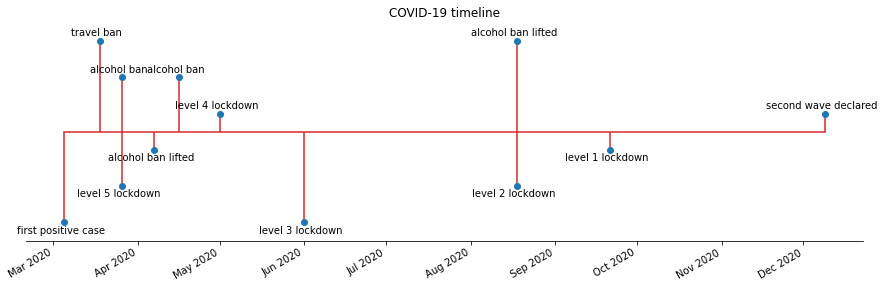

In [135]:
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(15, 4))
ax.set(title='COVID-19 timeline')

# create lines and set color to red
markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt='C3-',
                                         use_line_collection=True)

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, event, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords='offset points', va=va, ha='center')

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()

The first positive case was confirmed on the 5th of March. This was followed by a travel ban and the closure of schools 13 days later. On the 15th of March the president declared a national state of disaster and prohibited large gatherings. This was followed by a strict lockdown (level 5) and an alcohol ban. Since the start of level 5 lockdown regulations have been eased gradually until level 1 lockdown.

## Confirmed cases 

Next we look at the confirmed cases split into recoveries, active cases and deaths.

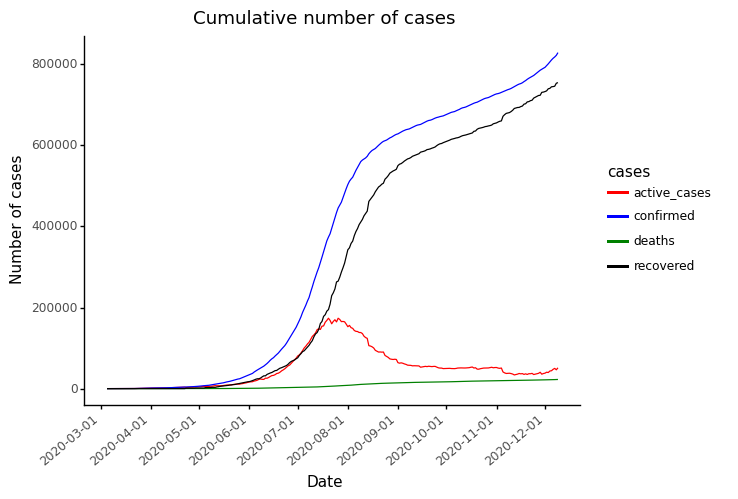

<ggplot: (110118451404)>

In [36]:
(ggplot(confirmed_cases, aes(x='date', y='number', color='cases'))
    + geom_line()
    + labs(x='Date', y='Number of cases', title='Cumulative number of cases')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + scale_color_manual(('red', 'blue', 'green', 'black'))
 )

Positive cases were at a minimum for approximately 2 months. We experienced an increase in positive cases between the beginning of June and mid-August, during Level 3 of lockdown. The number of cases started to stabilise until December and we are now seeing another increase in positive cases.

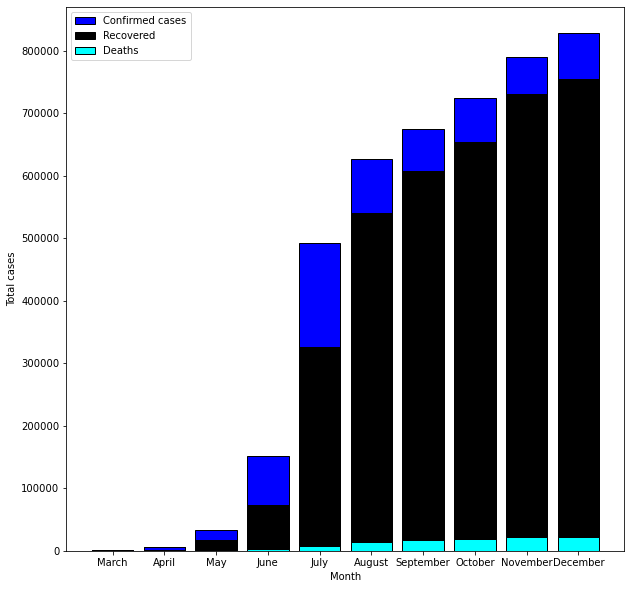

In [37]:
plt.figure(figsize=(10, 10))

# plot all cases in a bar graph
plt.bar(total_cases['month'], total_cases['confirmed'],
        color='blue', edgecolor='black', label='Confirmed cases')
plt.bar(total_cases['month'], total_cases['recovered'],
        color='black', edgecolor='black', label='Recovered')
plt.bar(total_cases['month'], total_cases['deaths'],
        color='cyan', edgecolor='black', label='Deaths')

plt.legend()

plt.ylabel('Total cases')
plt.xlabel('Month')

plt.show()

There has been a positive increase in the number of recoveries with a small proportion of confirmed cases resulting in death. Although the number of confirmed cases is rising we are seeing the majority of those resulting in recoveries.

## Daily cases

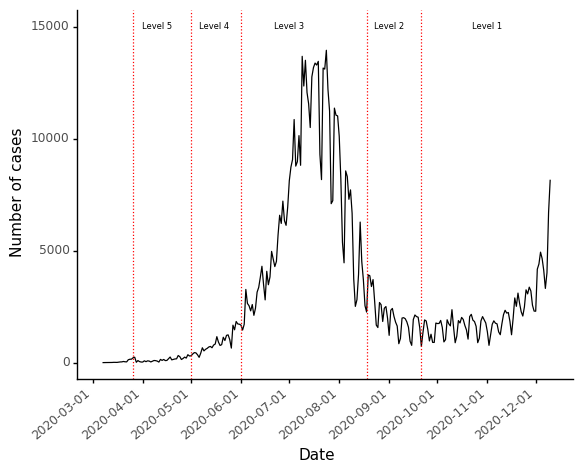

<ggplot: (-9223371909990391443)>

In [94]:
(ggplot(daily_cases, aes(x='date', y='confirmed'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()    
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + geom_vline(xintercept=['2020-03-26', '2020-05-01',
                             '2020-06-01', '2020-08-18', '2020-09-21'], 
                             linetype='dotted', color='red')
    + annotate('text', x='2020-04-10', y=15000, label='Level 5', size=6)
    + annotate('text', x='2020-05-15', y=15000, label='Level 4', size=6)
    + annotate('text', x='2020-07-01', y=15000, label='Level 3', size=6)
    + annotate('text', x='2020-09-01', y=15000, label='Level 2', size=6)
    + annotate('text', x='2020-11-01', y=15000, label='Level 1', size=6)
 )

The number of confirmed cases decreased during level 2 lockdown but since the start of December positive cases have been rising drastically resulting in a second wave of infections being declared by the Minister of Health Dr Zweli Mkhize.

## District data

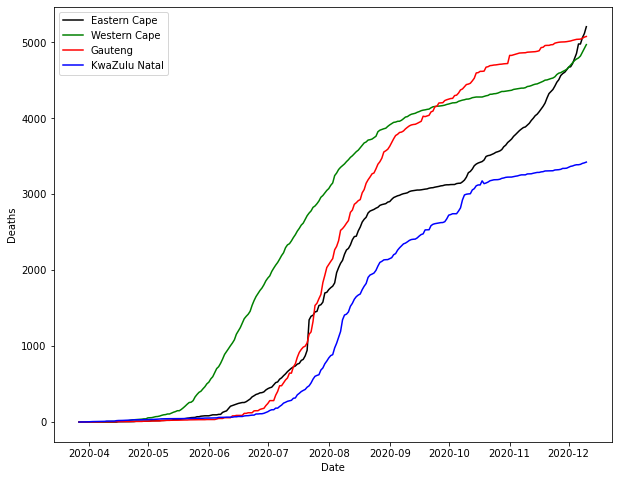

In [136]:
plt.figure(figsize=(10,8))

plt.plot(deaths['date'], deaths['EC'],
         color='black', label='Eastern Cape')
plt.plot(deaths['date'], deaths['WC'],
         color='green', label='Western Cape')
plt.plot(deaths['date'], deaths['GP'],
         color='red', label='Gauteng')
plt.plot(deaths['date'], deaths['KZN'],
         color='blue', label='KwaZulu Natal')
#plt.plot(deaths['date'], deaths['FS'],
 #        color='purple', label='Free State')
#plt.plot(deaths['date'], deaths['LP'],
 #        color='grey', label='Limpopo')
#plt.plot(deaths['date'], deaths['NW'],
 #        color='orange', label='North West')
#plt.plot(deaths['date'], deaths['NC'],
 #        color='navy', label='Northern Cape')
#plt.plot(deaths['date'], deaths['MP'],
 #        color='cyan', label='Mpumalanga')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Deaths')
plt.xlabel('Date')

plt.show()

The Western Cape, KwaZulu Natal, the Eastern Cape and Gauteng account for the majority of positive cases in the country. The Eastern Cape particularly has seen a surge in deaths from November while KwaZulu Natal and Gauteng deaths have been stable.

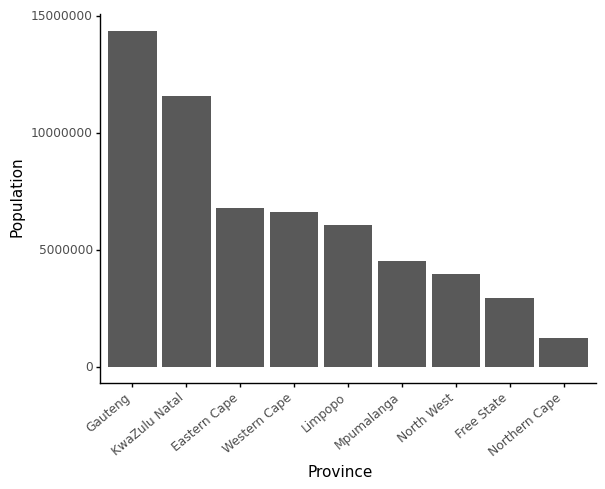

<ggplot: (-9223371909990318055)>

In [121]:
prov_list = ['Gauteng', 'KwaZulu Natal', 'Eastern Cape', 'Western Cape', 
             'Limpopo', 'Mpumalanga', 'North West', 'Free State', 'Northern Cape']

(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='Population'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Population')
    + scale_x_discrete(limits=prov_list)
 
 )

The provinces with the highest number of positive cases also have the highest population numbers in the countries.

### Health facilities

In [41]:
sa_map = plt.imread(
    r"https://raw.githubusercontent.com/ZintleFaltein/Covid-modelling/master/sa_map.png")

In [42]:
index = hospitals[hospitals['Long'] == '29.2805.5'].index
hospitals.drop(index, inplace=True)

hospitals['Long'] = hospitals['Long'].astype('float64')

coords = (hospitals.Long.min(),   hospitals.Long.max(),
          hospitals.Lat.min(), hospitals.Lat.max())

coords

(17.065201, 32.756375, -34.5372, -22.3416)

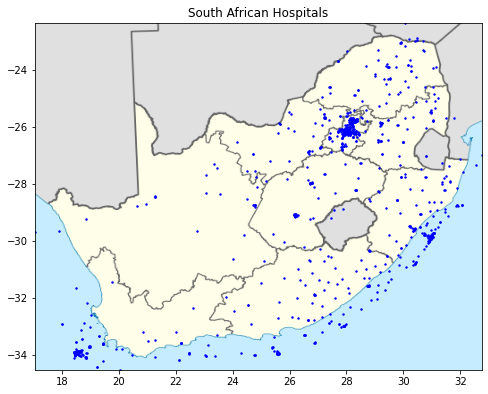

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(hospitals.Long, hospitals.Lat, zorder=2, color='b', s=2,)
ax.set_title('South African Hospitals')
ax.set_xlim(coords[0], coords[1])
ax.set_ylim(coords[2], coords[3])
ax.imshow(sa_map, zorder=1, extent=coords)

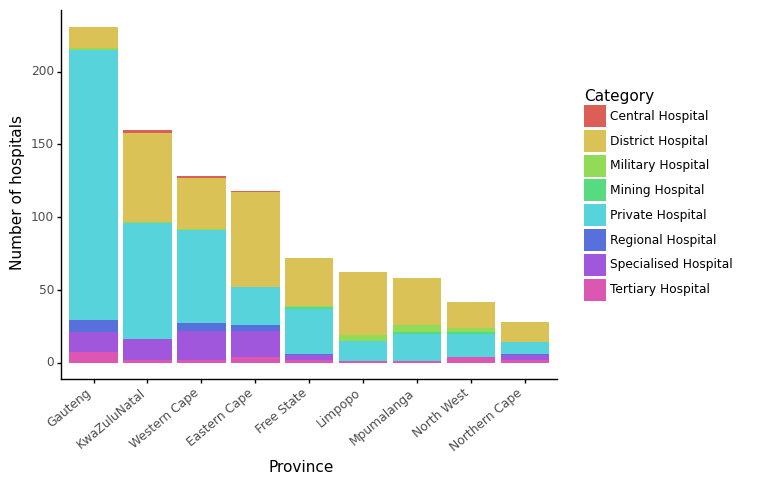

<ggplot: (-9223371909989750240)>

In [103]:
prov_list = hospitals['Province'].value_counts().index.tolist()

(ggplot(hospitals, aes(x='Province', fill='Category'))
    + geom_bar()
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + scale_x_discrete(limits=prov_list)
    + labs(x='Province', y='Number of hospitals')
 )

Gauteng, KwaZulu Natal and the Western cape have the highest number of hospitals compared to other provinces. The majority of hospitals are district and private hospitals.

In [100]:
index = health_facilities[health_facilities['Population'] == '5320 50'].index
health_facilities.drop(index, inplace=True)

health_facilities['Population'] = health_facilities['Population'].astype(
    'float64')

health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'EC', 'Eastern Cape')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'FS', 'Free State')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'GT', 'Gauteng')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'KZN', 'KwaZulu Natal')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'LIM', 'Limpopo')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'MP', 'Mpumalanga')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'NC', 'Northern Cape')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'NW', 'North West')
health_facilities['PROVINCE'] = health_facilities['PROVINCE'].replace(
    'WC', 'Western Cape')

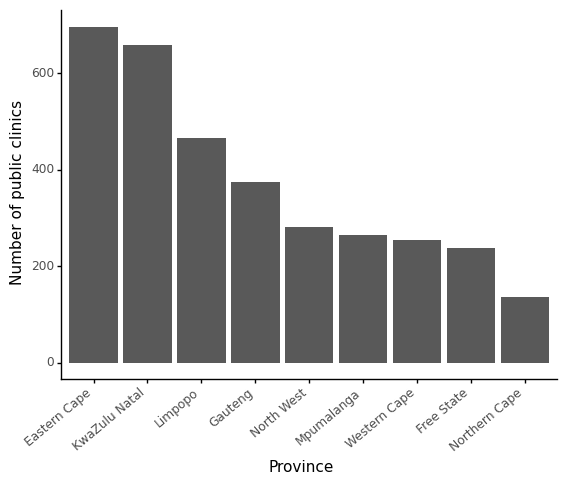

<ggplot: (-9223371909990553228)>

In [111]:
prov_list = ['Eastern Cape', 'KwaZulu Natal', 'Limpopo', 'Gauteng', 
             'North West', 'Mpumalanga', 'Western Cape', 'Free State', 'Northern Cape']

(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='No. Public clinics'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Number of public clinics')
    + scale_x_discrete(limits=prov_list)

 )

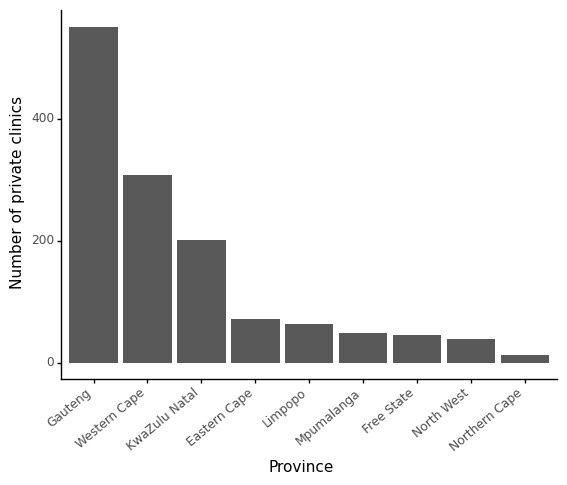

<ggplot: (126864405722)>

In [117]:
prov_list = ['Gauteng', 'Western Cape', 'KwaZulu Natal', 'Eastern Cape', 
             'Limpopo', 'Mpumalanga', 'Free State', 'North West', 'Northern Cape']

(ggplot(health_facilities)
    + geom_bar(aes(x='PROVINCE', y='No. Private Clinics'), stat='identity')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Province', y='Number of private clinics')
    + scale_x_discrete(limits=prov_list)

 )

Gauteng has the highest number of hospitals, and the majority of these are private hospitals. The majority of hospitals in KwaZulu Natal and the Western Cape are also private hospitals. The Eastern Cape has the fourth highest number of hospitals, and the highest number of public clinics. It is encouraging to see that the provinces with the most positive cases also have the highest number of health facilities. However, it is worth investigating further whether these have the capacity to provide the necessary health care for COVID patients.

## Effective reproductive number ($R_t$)

The effective reproductive number ($R_t$) of a virus indicates how infectious it is. It helps in estimating how many people will contract the virus from one person who is infected at a time. If the $R_t$ value is above 1 that indicates that the virus is highly infectious and will likely result in an epidemic. 

In [139]:
reproductive_rate['date'] = pd.to_datetime(
    reproductive_rate['date'], format='%Y-%m-%d')

total = reproductive_rate[reproductive_rate['state'] == 'Total RSA']
total.tail()

,state,date,ML,High_90,Low_90
1965,Total RSA,2020-12-05,1.12,0.0,0.0
1966,Total RSA,2020-12-06,1.08,0.0,0.0
1967,Total RSA,2020-12-07,1.08,0.0,0.0
1968,Total RSA,2020-12-08,1.22,0.0,0.0
1969,Total RSA,2020-12-09,1.38,0.0,0.0


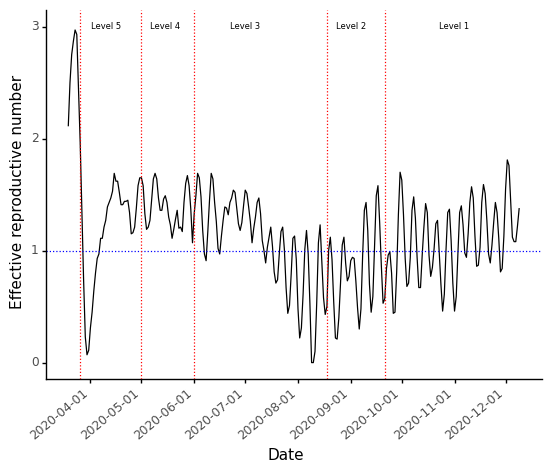

<ggplot: (126861765419)>

In [140]:
(ggplot(total, aes(x='date', y='ML'))
    + geom_line()
    + labs(x='Date', y='Effective reproductive number')
    + geom_hline(yintercept=1, linetype='dotted', color='blue')
    + geom_vline(xintercept=['2020-03-26', '2020-05-01',
                             '2020-06-01', '2020-08-18', '2020-09-21'],
                 linetype='dotted', color='red')
    + annotate('text', x='2020-04-10', y=3, label='Level 5', size=6)
    + annotate('text', x='2020-05-15', y=3, label='Level 4', size=6)
    + annotate('text', x='2020-07-01', y=3, label='Level 3', size=6)
    + annotate('text', x='2020-09-01', y=3, label='Level 2', size=6)
    + annotate('text', x='2020-11-01', y=3, label='Level 1', size=6)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

The $R_t$ for Covid-19 increased up to 3 before the lockdown was implemented. After lockdown restrictions were implemented the reproductive number remained between 1 and 2. Towards the end of level 3 lockdown the reproductive number decreased below 1 suggesting a decline in infection rates. Since the implementation of level 1 lockdown, however, we are seeing a slight increase in the reproductive number, suggesting that infection rates are rising again.

## Mobility report

In [141]:
mobility = mobility[mobility['province'] == 'Total']
mobility['date'] = pd.to_datetime(mobility['date'], format='%Y-%m-%d')

mobility = pd.melt(mobility, id_vars=['province', 'date'],
                   value_vars=['retail and recreation',
                               'grocery and pharmacy', 'parks',
                               'transit stations', 'workplaces',
                               'residential'])

In [51]:
mobility.head()

,province,date,variable,value
0,Total,2020-02-15,retail and recreation,4.0
1,Total,2020-02-16,retail and recreation,-3.0
2,Total,2020-02-17,retail and recreation,-10.0
3,Total,2020-02-18,retail and recreation,-12.0
4,Total,2020-02-19,retail and recreation,-12.0


This is a report that illustrates responses to social distancing during Covid-19 prepared by Google. The report shows changes in visits and length of stay in various public places (e.g restuarants, parks, grocery stores) compared to a baseline (the corresponding day of the week between 3rd January and 6th February 2020). 

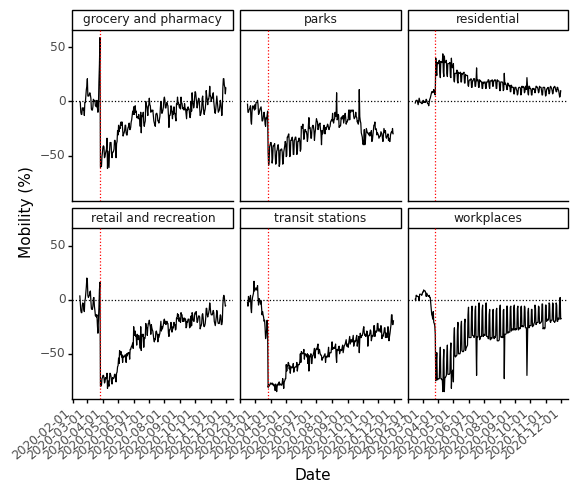

<ggplot: (-9223371909987052691)>

In [142]:
(ggplot(mobility, aes(x='date', y='value'))
    + geom_line()
    + facet_wrap('variable')
    + geom_hline(yintercept=0, linetype='dotted')
    + theme_classic()
 # + theme_seaborn(style='dark')
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x='Date', y='Mobility (%)')
    + geom_vline(xintercept=['2020-03-26'], linetype='dotted', color='red')
 )

The plot above shows changes in movement before and after the start of the lockdown. The black dashed line shows the baseline used to compare how movements have changed based on data obtained before the lockdown, and the red dashed line shows when lockdown level 5 was implemented. 

At the start of lockdown there was a decrease in the number of visits to public areas. Around the 26th of March there was a spike in the number of people visiting grocery stores and pharmacies, and this is possibly a result of people panic buying before going on lockdown. As lockdown restrictions were eased people started going out in public and spending less time at home.

With the easing of lockdown restrictions to level 1 people's movements are going back to normal, especially in recreational locations, workplaces and grocery stores.

# SIR Modelling

In order to model the spread of the virus without any lockdown interventions or social distancing we need to use the SIR model which requires the following parameters:
* *S* - the number of **susceptible** individuals. The assumption is that everyone in the population is susceptible and can   be infected
* *I* - the number of **infected** individuals who can spread the virus
* *R* - the number of **removed** individuals who have either passed away or recovered and cannot be re-infected

Two epidemiological quantities are also needed: the reproductive number and the recovery rate. The reproductive number of the virus when the first case was reported was 2.07.\
These are the basic equations that the model is built on:
* $\frac{dS}{dt}=-\beta.I.\frac{S}{N}$


* $\frac{dI}{dt}=\beta.I.\frac{S}{N} - \gamma.I$


* $\frac{dR}{dt}=\gamma.I$

The model assumes that the population stays the same and does not account for births and deaths that are not Covid-19 related. It also assumes that an individual who has recovered cannot get re-infected.\
The code for this model was obtained from scipython.com and the parameters used were obtained from Nyabadza _et al_., (2020).

In [143]:
# total population
N = 58775022

# recoveries & active infections
I0 = 1
R0 = 0

# susceptible
S0 = N - I0 - R0

# reproductive number
beta = 1.0598

# recovery rate
gamma = 0.4345

# social distancing parameter
rho = 0.453

# set the number of days to 180
t = np.linspace(0, 39, 40)

In [144]:
# SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = (beta * S * I / N) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [147]:
# initial conditions
y0 = S0, I0, R0
ret = odeint(sir_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# create a dataframe for S, I and R
infection_model = pd.DataFrame(
    {'susceptible': S,
     'infected': I,
     'recovered': R,
     'days': t})

In [148]:
infection_model.tail()

,susceptible,infected,recovered,days
35,9.060921e+06,4.659275e+06,4.505483e+07,35.0
36,8.419302e+06,3.531135e+06,4.682458e+07,36.0
37,7.965662e+06,2.650130e+06,4.815923e+07,37.0
38,7.642440e+06,1.975190e+06,4.915739e+07,38.0
39,7.410667e+06,1.464868e+06,4.989949e+07,39.0


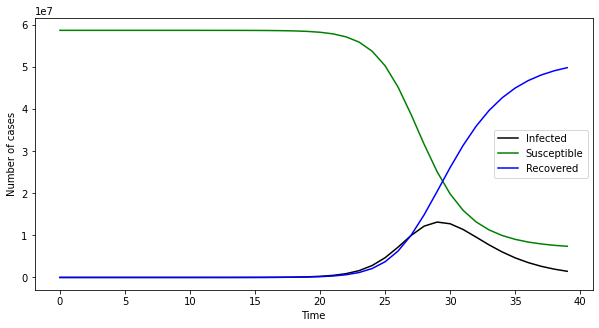

In [152]:
# plot the susceptible, infected and recovered numbers without any lockdown
plt.figure(figsize=(10, 5))

plt.plot(infection_model['days'], infection_model['infected'],
         color='black', label='Infected')
plt.plot(infection_model['days'], infection_model['susceptible'],
         color='green', label='Susceptible')
plt.plot(infection_model['days'], infection_model['recovered'],
         color='blue', label='Recovered')

plt.ylabel('Number of cases')
plt.xlabel('Time')

plt.legend()

plt.show()

The model predicts that the number of positive cases where no lockdown was implemented would have peaked 30 days after the first positive case was reported. The maximum number of infections would have reached 1 million individuals. 

A comparison of the modeled cases and the actual confirmed cases shows that the lockdown restrictions and social distancing measures put in place were effective in containing the spread of the virus and delaying the peak in infections.

# Conclusion

The data presented here shows the evolution of infections related to Covid-19 in South Africa, from the confirmation of the first case in early March. The virus was introduced in the country by individuals who had traveled to high risk countries, and 21 days after the first case was reported a national lockdown was implemented. Based on the analysis of people's movements and the decrease in the effective reproductive number over time, we can see that the implementation of the lockdown and the travel ban was effective in containing the spread of the virus. This is also evident in the comparison between modeled cases and actual confirmed cases where the actual cases show a delayed peak with only 525 242 cases confirmed between July and August. The early implementation of the lockdown helped delay the peak in infections by 3 months

Even though lockdown restrictions were eased and schools were opened during level 2 and level 1, the effective reproductive number still decreased and the rate of infection stabilized. This could be as a result of people being informed on how the virus spreads and following social distancing protocols that have reduced the spread. The beginning of December, however, resulted in an increase in positive cases and stricter restrictions in hotspots across the country. On the 9th of December the Minister of health Dr Zweli Mkhize declared that the country is experiencing a second wave of infections showing that positive cases are increasing drastically throughout the country, particularly in the Western Cape, KwaZulu Natal and the Eastern Cape.

# References

1. https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

2. Data Science for Social Impact Research Group @ University of Pretoria, Coronavirus COVID-19 (2019-nCoV) Data Repository for South Africa. Available on: https://github.com/dsfsi/covid19za.

3. Nyabadza, F., Chirove, F., Chukwu, W., Visaya, M., 2020. Modelling the potential impact of social distancing on the COVID-19 epidemic in South Africa. medRxiv 1–17.